# Проект "Прогнозирование заказов такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка

In [14]:
#!pip install statsmodels

In [15]:
#!pip install catboost

In [16]:
!pip install lightgbm

In [17]:
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import warnings
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import Pool, CatBoostRegressor, cv
warnings.filterwarnings('ignore')

In [18]:
try:
    taxi_data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
except:
    taxi_data = pd.read_csv('C:\\Data\\taxi.csv', parse_dates=[0], index_col=[0])

In [19]:
taxi_data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [20]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [21]:
taxi_data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [22]:
taxi_data.isna().sum()

num_orders    0
dtype: int64

In [23]:
taxi_data.sort_index() #Отсортируем индексы по возрастанию

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [24]:
taxi_data.index.is_monotonic #Проверим функцию на монотонность, чтобы посмотреть, расположены ли в хронологическом порядке данные

True

In [25]:
taxi_data = taxi_data.resample('1H').sum() #Сделаем ресемплинг по первому часу

**Вывод** Мы загрузили данные из файла где имеется информация от 01.03.2018 года по 31.03.18. Мы перевели данные с Dtetime на Datetime64 и установили инекс раный столбцу Datetime. Пропуски отсутствуют.

## 2. Анализ

Построим график временного ряда

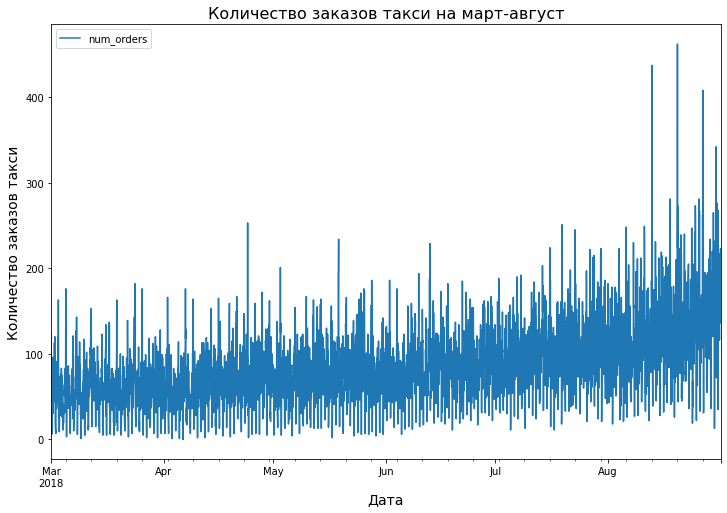

In [26]:
taxi_data.plot(figsize=(12,8))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.title('Количество заказов такси на март-август', fontsize=16)
plt.legend()
plt.show()

Разложим временной ряд на сезонный компонент и тренд. Для корректной визуализации графика указываем оси ax=plt.gca, чтобы получить текущие оси

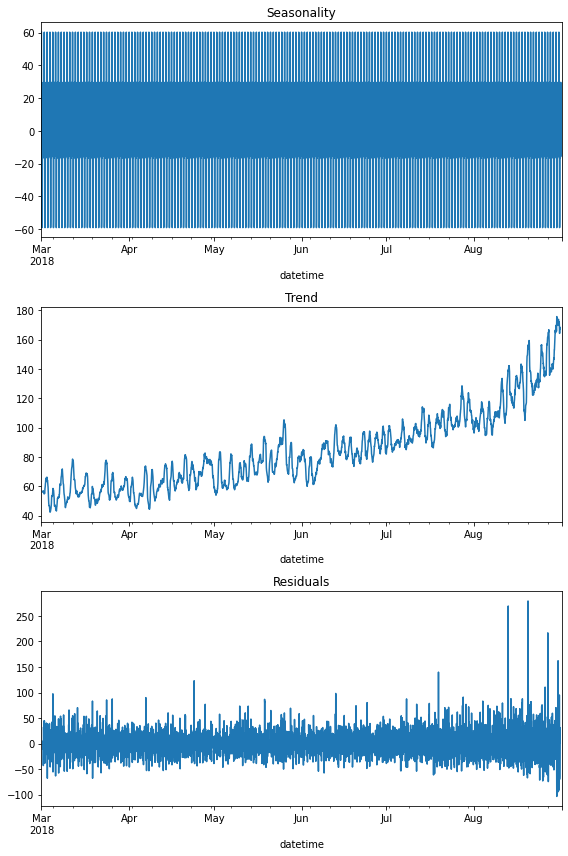

In [27]:
decomposed = seasonal_decompose(taxi_data)

plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь необходимо построить график сезонной составляющей за июль

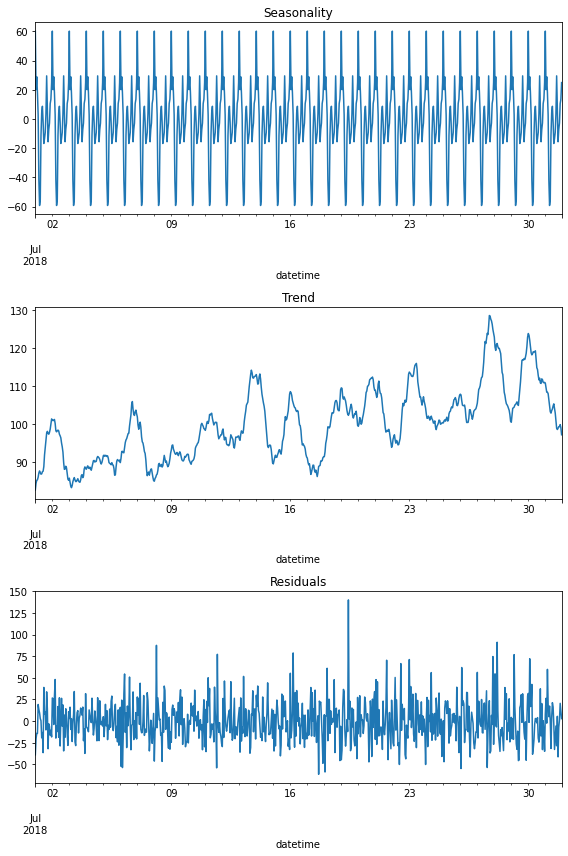

In [28]:
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику мы видим, что имеется тренд на увеличение количество заказов с течением времени.

Теперь рассмотрим тренд с периодичностью в два дня.

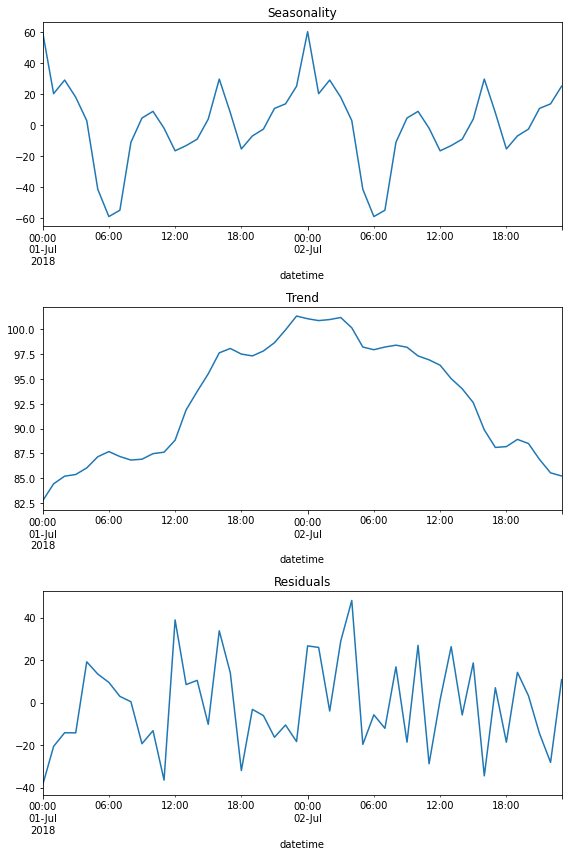

In [29]:
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графиков видно, что число заказов становится больше к получночи, а меньше всего к 6 утра.

Теперь неоходимо проверить стационарность временного ряда. Для этого найдём размерность временного ряда - набор разностей между соседним временным рядом.

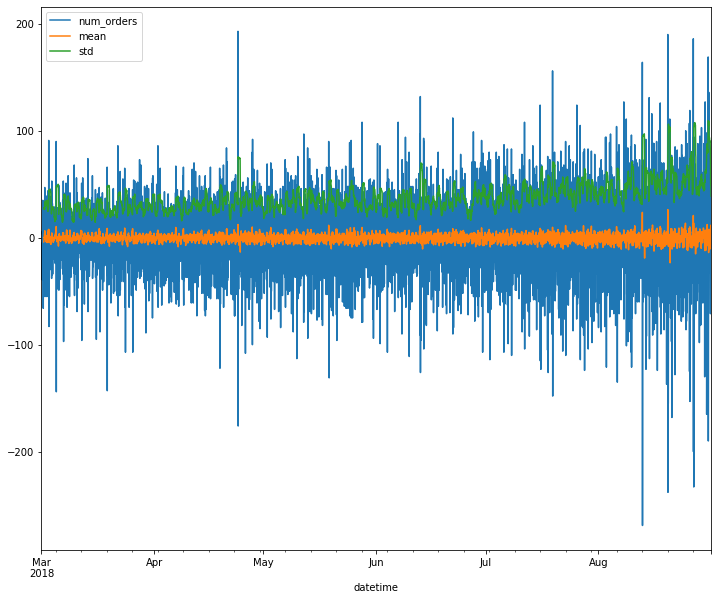

In [30]:
taxi_data_1 = taxi_data - taxi_data.shift()
taxi_data_1['mean'] = taxi_data_1['num_orders'].rolling(15).mean()
taxi_data_1['std'] = taxi_data_1['num_orders'].rolling(15).std()
taxi_data_1.plot(figsize=(12,10))
plt.show()

Ряд стационарен, поскольку его среднее значение и стандартное отклаение не сильно меняются.

Теперь проведет тест Дики-Фуллера

In [31]:
result = adfuller(taxi_data['num_orders'])
print('ADF Statistic: {}'.format(result[0]))
print('p.value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
    print('\t {}:{}'.format(key, value))

ADF Statistic: -3.0689242890279558
p.value: 0.028940051402612906
Critical values:
	 1%:-3.431842162413052
	 5%:-2.8621993540813637
	 10%:-2.567120978470452


Исходя из того, что p-value меньше порогового значения, что мы отвергаем нулеую гипотезу о нестационарности ряда и принммаем альтернативную, что он стационарен.

Теперь создадим признаки для решения задач прогнозирования.

Создадим признаки для планирования в 1 шаг.

In [32]:
def make_features(taxi_data, max_lag, rolling_mean_size):
    #taxi_data['month'] = taxi_data.index.month
    taxi_data['day'] = taxi_data.index.day
    taxi_data['dayofweek'] = taxi_data.index.dayofweek
    taxi_data['hour'] = taxi_data.index.dayofweek
    
    #Вычислим отстающие значения, затем добавим аргумент max_lag, который задаст максимальный размер отставания
    #Новые признаки будут называться lag_1, lag_2 и до величины max_lag
    
    for lag in range(1, max_lag + 1):
        taxi_data['lag_{}'.format(lag)] = taxi_data['num_orders'].shift(lag)
    
    #Вычислим также среднее скользящее значение и добавим его в качестве признака rolling_mean

    taxi_data['rolling_mean'] = taxi_data['num_orders'].shift().rolling(rolling_mean_size).mean()

# Зададим отстающие признаки - 24, скользящее среднее - 10

make_features(taxi_data, 24, 10)
print(taxi_data.head())

                     num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-01 00:00:00         124    1          3     3    NaN    NaN    NaN   
2018-03-01 01:00:00          85    1          3     3  124.0    NaN    NaN   
2018-03-01 02:00:00          71    1          3     3   85.0  124.0    NaN   
2018-03-01 03:00:00          66    1          3     3   71.0   85.0  124.0   
2018-03-01 04:00:00          43    1          3     3   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...   

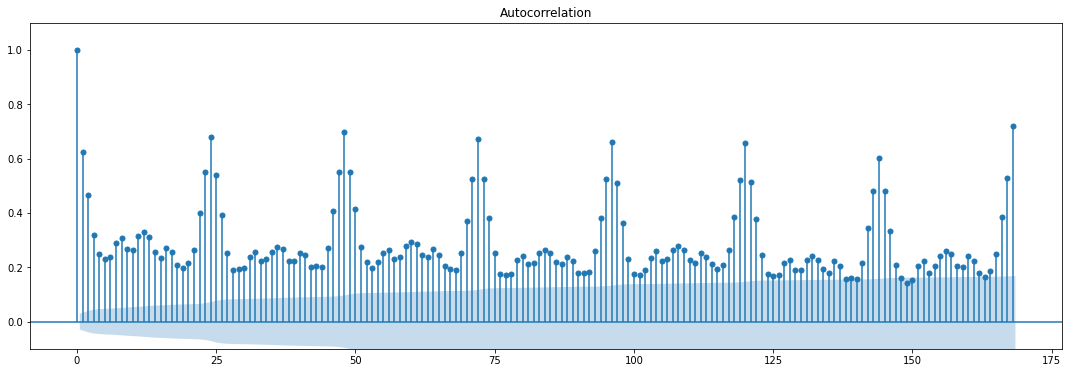

In [33]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 168)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


Удалим пропуски.

In [34]:
taxi_data.dropna(inplace=True)

In [35]:
taxi_data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,2,4,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,2,4,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,2,4,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


In [36]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   day           4392 non-null   int64  
 2   dayofweek     4392 non-null   int64  
 3   hour          4392 non-null   int64  
 4   lag_1         4392 non-null   float64
 5   lag_2         4392 non-null   float64
 6   lag_3         4392 non-null   float64
 7   lag_4         4392 non-null   float64
 8   lag_5         4392 non-null   float64
 9   lag_6         4392 non-null   float64
 10  lag_7         4392 non-null   float64
 11  lag_8         4392 non-null   float64
 12  lag_9         4392 non-null   float64
 13  lag_10        4392 non-null   float64
 14  lag_11        4392 non-null   float64
 15  lag_12        4392 non-null   float64
 16  lag_13        4392 non-null   float64
 17  lag_14        4392 non-null

**Вывод**

В данном разделе мы занимались анализом временных рядов. Сначала рассмотрели весь июль, а потом период в 2 дня. Мы выявили тренд, что заказы увеличиваются с течением времени и пик приходится на полночь. Также мы проверили данные на стационарность ременного ряда. Мы таже создали признаки для месяца, дня недели, отстающие признаки и скользящее среднее. Затем мы удалили пропуски и получили таблицу с 29 признаками, которая готова для построения модели.

# 3. Обучение

Разделим данные на обучающую и тестовые выборки и построим разные модели и найдём для них лучшие гиперпараметры. 

In [37]:
train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#Выведем размер выборок
display(train.shape)
display(test.shape)

#Проведем проверку корректности деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3952, 29)

(440, 29)

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


**Линейная регрессия**

In [38]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [39]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
regression_cv_score = pd.Series(cross_val_score(model_lr, features_train, target_train, scoring=RMSE_score, cv=3)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации', regression_cv_score)
#train_predict = model.predict(features_train)
#rmse = mean_squared_error(target_train, train_predict)**0.5
#print(rmse)

Среднее качество модели линейной регрессии на кросс-валидации 26.17296677278644


**Модель случайного леса**

In [40]:
#Разделим данные на обучающую и тестовую выборки
#df_train_rf, df_test_rf = train_test_split(taxi_data, test_size=0.20, shuffle=False, random_state=12345)

#features_train_rf = df_train_rf.drop(['num_orders'], axis=1)
#target_train_rf = df_train_rf['num_orders']

#Разделим данные на валидационную и тестовую выборки
#df_valid_rf, df_test_rf = train_test_split(df_test_rf, test_size=0.50, random_state=12345)

##создадим в валидационной и тестовой выборках переменные для признаков и целевого признака
#features_valid_rf = df_valid_rf.drop(['num_orders'], axis=1)
#target_valid_rf = df_valid_rf['num_orders']
#features_test_rf = df_test_rf.drop(['num_orders'], axis=1)
#target_test_rf = df_test_rf['num_orders']

Проверяем деление выборок.

In [41]:
#print(df_train_rf.shape)
#print(df_test_rf.shape)
#print(df_valid_rf.shape)

Найдём наилучшую глубину дерева

In [42]:
#%%time

#for depth in range(3, 20, 3):
    #model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    #model_dt.fit(features_train, target_train)
    #dt_cv_score = pd.Series(cross_val_score(model_dt, features_train, target_train, scoring=RMSE_score, cv=3)).mean()*(-1)
    #predictions_valid_dt = model.predict(features_valid_rf)
    #rmse = mean_squared_error(target_valid_rf, predictions_valid_rf)**0.5
    #print('Глубина:',depth)
    #print('Среднее качество модели решающего дерева на кросс-валидации', dt_cv_score)
    #print('RMSE решающего дерева', rmse)
    
    

In [43]:
%%time

model_dt = DecisionTreeRegressor(random_state=12345, max_depth=15)
model_dt.fit(features_train, target_train)

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
time_split = TimeSeriesSplit(n_splits=5)

CPU times: user 76.7 ms, sys: 702 µs, total: 77.4 ms
Wall time: 76.7 ms


In [44]:
%%time

tuning_model = GridSearchCV(estimator=model_dt, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=time_split, verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV 2/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV 4/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV 5/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV 1/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV 2/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV 3/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV 4/5] END max_depth=None, max_features=auto, min_samples_leaf=1, min_s

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10}

31.849165891478236

CPU times: user 11.4 s, sys: 212 ms, total: 11.6 s
Wall time: 11.8 s


Найдём наилучшее количество деревьев

In [45]:
#%%time

#for est in [100, 500, 1000]:
    #model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=15)
    #model_rf.fit(features_train, target_train)
    #rf_cv_score = pd.Series(cross_val_score(model_rf, features_train, target_train, scoring=RMSE_score, cv=3)).mean()*(-1)
    #predictions_valid_rf = model.predict(features_valid_rf)
    #rmse = mean_squared_error(target_valid_rf, predictions_valid_rf)**0.5
    #print('Количество деревьев', est)
    #print('')
    #print('Среднее качество модели случайного леса на кросс-валидации', rf_cv_score)
    #print('RMSE случайного леса', rmse)

In [46]:
#param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

In [47]:
%%time

model_rf = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=15)
model_rf.fit(features_train, target_train)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}
time_split = TimeSeriesSplit(n_splits=5)

CPU times: user 4.81 s, sys: 81 ms, total: 4.89 s
Wall time: 4.9 s


In [48]:
%%time

tuning_model = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=time_split, verbose=0)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

25.50866923202269

CPU times: user 16min 3s, sys: 6.25 s, total: 16min 9s
Wall time: 16min 13s


Проверим данные на тестовой выборке

In [49]:
#model = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=15)
#model.fit(features_train_rf, target_train_rf)
#features_train_rf = pd.concat([features_train_rf, features_valid_rf])
#target_train_rf = pd.concat([target_train_rf, target_valid_rf])
#model.fit(features_train_rf, target_train_rf)
#predict = model.predict(features_test_rf)
#print(mean_squared_error(target_test, predict, squared=False))

**LigthGMB**

In [50]:
model_lgb = lgb.LGBMRegressor(random_state=12345)
model_lgb.fit(features_train, target_train)
#lgb_cv_score = pd.Series(cross_val_score(model_lgb, features_train, target_train, scoring=RMSE_score, cv=3)).mean()*(-1)
#print('Среднее качество модели LigthGMB на кросс-валидации', lgb_cv_score)

#predictions_test = model.predict(features_test)
#rmse = mean_squared_error(target_test, predictions_test)**0.5
#print(rmse)

LGBMRegressor(random_state=12345)

Найдём лучшие гиперпараметры

In [51]:
%%time

param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}
def fit_model(estimator, param_grid, features_train, target_train, features_test, target_test):
    time_split = TimeSeriesSplit(n_splits=5)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.9 µs


In [ ]:
%%time

tuning_model = GridSearchCV(estimator=model_lgb, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=time_split, verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ................n_estimators=100, num_leaves=20; total time=   0.6s
[CV 2/5] END ................n_estimators=100, num_leaves=20; total time=   0.8s
[CV 3/5] END ................n_estimators=100, num_leaves=20; total time=   0.9s
[CV 4/5] END ................n_estimators=100, num_leaves=20; total time=   0.8s
[CV 5/5] END ................n_estimators=100, num_leaves=20; total time=   0.9s
[CV 1/5] END ................n_estimators=100, num_leaves=40; total time=   1.0s
[CV 2/5] END ................n_estimators=100, num_leaves=40; total time=   1.5s
[CV 3/5] END ................n_estimators=100, num_leaves=40; total time=   3.6s
[CV 4/5] END ................n_estimators=100, num_leaves=40; total time=   2.5s
[CV 5/5] END ................n_estimators=100, num_leaves=40; total time=   1.4s
[CV 1/5] END ................n_estimators=100, num_leaves=60; total time=   0.8s
[CV 2/5] END ................n_estimators=100, 

**Вывод**

Мы разделили нашу выборку на тестовую, обучающую и валидационную. Получили модели линейной регрессии, решающего дерева и случайного леса. Наилучшее значение метрики RMSE полуилось у LGBM. Соответственно, на ней будем проводить тестирование модели.

# 4. Тестирование

Проверим лучшую модель на тестовой выборке

In [ ]:
model = lgb.LGBMRegressor(random_state=12345, n_estimators=100, num_leaves=20)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

Теперь построим график для исходных и предсказанных данных

In [ ]:
predictions_test = pd.Series(predictions_test, index=target_test.index)
plt.figure(figsize=(20, 10))
plt.xlabel('дата', fontsize=14)
plt.ylabel('Число заказов', fontsize=14)
plt.plot(target_test, label='Исходная выборка')
plt.plot(predictions_test, label='предсказания')
plt.legend(fontsize=14)
plt.show()

In [ ]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse = mean_squared_error(target_test, pred_previous)**0.5

**Вывод**

RMSE на тестовой выборке составляет 41,34, что меньше 48 по условию задачи. Модель имеет адекватное предсказание с небольшими ошибками в некоторых участках.

# Общий вывод

Мы загрузили данные за март 2018 года по заказам такси. Мы перевели данные с Dtetime на Datetime64 и установили инекс раный столбцу Datetime. Пропуски отсутствуют.

Мы проанализировали весь июль, а потом период в 2 дня. Мы выявили тренд, что заказы увеличиваются с течением времени и пик приходится на полночь. Также мы проверили данные на стационарность ременного ряда. Мы таже создали признаки для месяца, дня недели, отстающие признаки и скользящее среднее. Затем мы удалили пропуски и получили таблицу с 29 признаками, которая готова для построения модели.

Мы разделили нашу выборку на тестовую, обучающую и валидационную. Получили модели линейной регрессии, решающего дерева и случайного леса. Наилучшее значение метрики RMSE полуилось у LGBM.

В итоге RMSE 41,34 что меньше 48, что соответствует условию задачи.